In [316]:
#Import libraries and functions

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob #pattern package to find filename
from skimage.io import imread
from scipy import ndimage
from scipy.ndimage import shift
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit

In [317]:
#Some constants

kb = 8.62e-2 #in units of meV/K

In [318]:
#Material-specific lattice parameters (in angstrom)

a = 4.36138
c = 40.92263

lattice_para = np.array([[a*np.cos(np.pi/6), a*np.sin(np.pi/6), 0], \
                         [a*np.cos(5*np.pi/6), a*np.sin(5*np.pi/6), 0], \
                         [0, 0, c]])

ra = 4*np.pi/(np.sqrt(3)*a)
rc = 2*np.pi/c

rec_lattice_para = np.array([[ra*np.cos(np.pi/3), ra*np.sin(np.pi/3), 0], \
                             [ra*np.cos(np.pi), ra*np.sin(np.pi), 0], \
                             [0, 0, rc]])


In [319]:
#Defining some functions

##Rotation matrix for an in-plane rotation of x_deg degrees

def rot(x_deg):
    theta = np.radians(x_deg)
    c, s = np.cos(theta), np.sin(theta)
    rot_mat = np.array([[c, -s, 0],[s, c, 0], [0, 0, 1]])
    return rot_mat

##Functions that return Q, K, and q for a given (h, k, l), in units of A^-1

def Q(h, k, l):
    return h*rec_lattice_para[0] + k*rec_lattice_para[1] + l*rec_lattice_para[2]

def K(h, k, l):
    d_test = 10 #this will store the minimum norm for comparison (10 is just an arbitrary number)
    m_test = 1 #this will store the integer m corresponding to minimum norm
    n_test = 1 #this will store the integer n corresponding to minimum norm
    for m in np.arange(np.rint(h)-2, np.rint(h)+2, 1):
        for n in np.arange(np.rint(k)-2, np.rint(k)+2, 1):
            d = (h - m)**2 + (k - n)**2 - (h - m)*(k - n)
            if d < d_test:
                d_test = d
                m_test = m
                n_test = n
    #print(d_test)
    #print(m_test)
    #print(n_test)
    return m_test*rec_lattice_para[0] + n_test*rec_lattice_para[1] + np.rint(l)*rec_lattice_para[2]
            
def q(h, k, l):
    return Q(h, k, l) - K(h, k, l) 

##Bringing arbitrary q into irreducible Brillouin zone as defined in notes, and the rotation angle needed

def q_ibz(h, k, l):
    qtemp = q(h, k, l)   
    count = 0
    
    while True:
        if (qtemp[0] <= ra*0.51) & (qtemp[0] - qtemp[1]*1.73 >= 0) & (qtemp[0] + qtemp[1]*1.73 >= 0):
            break
        else:
            qtemp = np.transpose(np.matmul(rot(60), np.transpose(qtemp)))
            count += 1
    angle = 60*(6 - count)
    return np.array([qtemp, angle])

##Angle by which q has to be rotated to bring it into IBZ

def q_ibz_rot_angle(h, k, l): 
    qtemp = q(h, k, l)
 
    while True:
        if (qtemp[0] <= ra*0.51) & (qtemp[0] - qtemp[1]*1.73 >= 0) & (qtemp[0] + qtemp[1]*1.73 >= 0):
            break
        else:
            qtemp = np.transpose(np.matmul(rot(60), np.transpose(qtemp)))
            count += 1
    angle = 60*(6 - count)
    return angle

##Function that returns r = xa + yb + zc for a given x, y, z, in units of A

def R(x, y, z):
    return x*lattice_para[0] + y*lattice_para[1] + z*lattice_para[2]

##Exception for division by zero

def div(n, d):
    return n/d if d > 0.15 else 0

##Boltzmann statistics function
##This is for the given phonon dispersion relation

def n(h, k, l):
    return np.exp(-w(h, k, l)/(kb*T))

In [320]:
#Importing material-specific unit cell coordinates and other parameters

##Fractional unit cell coordinates of all atoms - Mn (3), Bi (6), Te (12) = 21 atoms in hexagonal unit cell.
          
unit_r_Mn = np.array([R(0, 0, 0), R(2/3, 1/3, 1/3), R(1/3, 2/3, 2/3)])
unit_r_Bi = np.array([R(0, 0, 0.42), R(0, 0, 0.57), R(0.67, 0.33, 0.75), R(0.67, 0.33, 0.91), R(0.33, 0.67, 0.09), R(0.33, 0.67, 0.24)])
unit_r_Te = np.array([R(0, 0, 0.13), R(0, 0, 0.86), R(0.67, 0.33, 0.47), R(0.67, 0.33, 0.2), R(0.33, 0.67, 0.8), R(0.33, 0.67, 0.53), R(0, 0, 0.3), R(0, 0, 0.7), R(0.67, 0.33, 0.63), R(0.67, 0.33, 0.04), R(0.33, 0.67, 0.96), R(0.33, 0.67, 0.37)])                    

unit_r = np.concatenate((unit_r_Mn, unit_r_Bi, unit_r_Te), axis = 0)

##Importing Debye-Waller information

B_Mn = 0.05*np.ones(3)
B_Bi = 0.05*np.ones(6)
B_Te = 0.05*np.ones(12)

B = np.concatenate((B_Mn, B_Bi, B_Te), axis = 0)

##Importing atomic structure factor information - for now just assuming constants, ignoring the Q-dependence.

f_Mn = np.ones(3)
f_Bi = np.ones(6)
f_Te = np.ones(12)

f = np.concatenate((f_Mn, f_Bi, f_Te), axis = 0)

##Importing atomic mass information

m_Mn = np.ones(3)
m_Bi = np.ones(6)
m_Te = np.ones(12)

m = np.concatenate((m_Mn, m_Bi, m_Te), axis = 0)

In [321]:
#Material-specific physical parameters. For now, we use functional forms for everything.

##Phonon energy as a function of h, k, l, assuming linear dispersion of an acoustic phonon. This is in units of meV.
##Normalized such that the highest phonon energy (at zone boundary) is 5 meV ~ 1 THz.

def w(h, k, l):
#      return 5*(np.linalg.norm(q(h, k, l)))/np.linalg.norm(Q(0.5, 0.5, 0.5)) 
    return 4

##Transverse acoustic phonon eigenvector

def e_t(h, k, l):
    e_t_temp = np.cross(q(h, k, l), [0, 0, 1]) #To find the direction perpendicular to a phonon wavevector in the xy plane.
    if np.linalg.norm(e_t_temp) != 0: #Avoiding division by zero.
        return e_t_temp/np.linalg.norm(e_t_temp)
    else:
        return e_t_temp

##Longitudinal acoustic phonon eigenvector

def e_l(h, k, l):
    e_l_temp = q(h, k, l)
    if np.linalg.norm(e_l_temp) != 0: #Avoiding division by zero.
        return e_l_temp/np.linalg.norm(e_l_temp)
    else:
        return e_l_temp    
    

In [322]:
#Importing Phonopy files - Q mesh and YAML file

path = 'C:/Users/Hari/OneDrive/Research/Ultrafast Optics/SLAC/sim-phonon-struct/'

##Import q-point mesh in hexagonal coordinates

qmesh_hex = np.array(np.loadtxt(path + 'python_qpoints_hex.txt'))
qmesh_cart = qmesh_hex*0

###converting from hexagonal to cartesian
for i in range(0, np.shape(qmesh_cart)[0]):
    qmesh_cart[i] = q(qmesh_hex[i, 0], qmesh_hex[i, 1], qmesh_hex[i, 2])
    
##Import yaml file

from pymatgen.io.phonopy import get_ph_bs_symm_line
yaml = get_ph_bs_symm_line(path + "qpoints.yaml")
# print(qmesh_cart)

In [323]:
yaml.band_reorder()     

eigendispl = yaml.eigendisplacements 
# print(np.shape(eigendispl))

# print(np.shape(qmesh_cart))

# # print(q_ibz(0, 0.5, 0) - qmesh_cart[0])

# # print(np.radians(q_ibz_rot_angle(0, 0.2, 0)))

# print(q_ibz(0, -0.2, 0)[1])

# atom_dict = {0:0, 1:0, 2:0, \
#              3:2, 4:2, 5:1, 6:1, 7:1, 8:1, \
#              9:6, 10:6, 11:3, 12:3, 13:5, 14:5, 15:6, 16:6, 17:3, 18:3, 19:5, 20:5}

# atom_dict[9]

In [324]:
phonon = 15 #phonon mode number

##Dictionary to conert atom index in conventional unit cell to atom index in primitive unit cell
atom_dict = {0:0, 1:0, 2:0, \
             3:2, 4:2, 5:1, 6:1, 7:1, 8:1, \
             9:6, 10:6, 11:3, 12:3, 13:5, 14:5, 15:6, 16:6, 17:3, 18:3, 19:5, 20:5}

def eigenvec(h, k, l, atom): #here the atom index is as defined in the conventional unit cell
    test = 10
    
    for i in range(0, np.shape(qmesh_cart)[0]):
#         print(i)
        qtemp = q_ibz(h, k, l)[0]
        if np.linalg.norm(qtemp - qmesh_cart[i]) < test: ##finding the q from q-mesh that is closest to q_ibz
            test = np.linalg.norm(qtemp - qmesh_cart[i])
            qmin = qmesh_cart[i]
            imin = i
#             print(imin)
    edispl_unrot = np.array(np.real(eigendispl[phonon, imin, atom_dict[atom]])) 
    edispl = np.transpose(np.matmul(rot(q_ibz(h, k, l)[1]), np.transpose(edispl_unrot)))
    
    return edispl

# print(eigenvec(0.1, -0.4, 0, 13))

In [325]:
# #Function that outputs the structure factor, taking as inputs the (h, k, l), DW factor B, and unit cell r.
# ##This is only for acoustic phonons, so the eigenvector is the same for all atoms.

# def F(h, k, l, f, m, B, r):
#     f_sum = 0
#     for i in np.arange(0, np.shape(r)[0]): #sum over all the atoms in unit cell

#         f_sum = f_sum + (f[i]/m[i]**0.5)*np.exp(-B[i]*(np.linalg.norm(Q(h, k, l))**2))\
#                 *np.dot(Q(h, k, l), e_t(h, k, l))*np.exp(-1j*np.dot(K(h, k, l), r[i]))


#     return f_sum    

In [326]:
#Function that outputs the structure factor, taking as inputs the (h, k, l), DW factor B, and unit cell r.
##This is for a specific optical phonon.

def F(h, k, l, f, m, B, r):
    f_sum = 0
    for atom in np.arange(0, np.shape(r)[0]): #index is over all the atoms in unit cell
        
        f_sum = f_sum + f[atom]*np.exp(-B[atom]*(np.linalg.norm(Q(h, k, l))**2))\
                *np.dot(Q(h, k, l), eigenvec(h, k, l, atom))*np.exp(-1j*np.dot(K(h, k, l), r[atom]))

#         f_sum = f_sum + (f[i]/m[i]**0.5)*np.exp(-B[i]*(np.linalg.norm(Q(h, k, l))**2))*np.dot(Q(h, k, l), eVector[i])*np.exp(-1j*np.dot(K(h, k, l), r[i]))

    return f_sum    

In [327]:
##Select atoms of unit cell to analyze - Comment out lines if all atoms are to be analyzed

# unit_r = unit_r_Bi
# B = B_Bi
# m = m_Bi

In [328]:
h_i = -5
h_f = 5
k_i = -5
k_f = 5

##Create arrays with x, y for integer h, k, l

data_int = np.zeros(((h_f-h_i)*(k_f-k_i),3))

i = 0

for h in np.arange(h_i, h_f, 1):
    for k in np.arange(k_i, k_f, 1):
        
        data_int[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0]
        #print(data_int[i])
        i = i + 1
        
x_int = data_int[:,0]
y_int = data_int[:,1]

##Create arrays with x, y for integer h, k, l satisfying Bragg condition

data_int_bragg = np.zeros(((h_f-h_i)*(k_f-k_i),3))

i = 0

for h in np.arange(h_i, h_f, 1):
    for k in np.arange(k_i, k_f, 1):
        
        ###Sum over phase factors to check for selection rule
        temp_sum = 0
        for j in np.arange(0, np.shape(unit_r)[0]): #sum over all the atoms in unit cell
            temp_sum = temp_sum + np.exp(-1j*np.dot(K(h, k, 0), unit_r[j]))
            
        #print(temp_sum) #to debug forbidden Bragg peaks
        
        if np.abs(temp_sum) > 10:
            data_int_bragg[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0]
            #print(data_int[i])
        i = i + 1

x_int_bragg = data_int_bragg[:,0]
y_int_bragg = data_int_bragg[:,1]

<IPython.core.display.Javascript object>


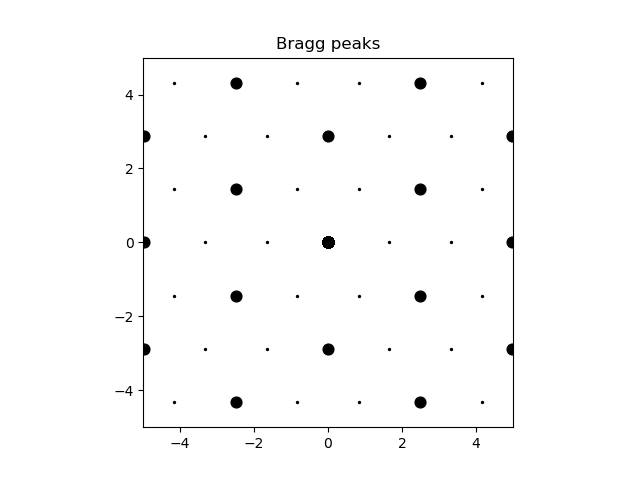

Text(0.5, 1.0, 'Bragg peaks')

In [329]:
##Plot Bragg peaks

fig1, ax1 = plt.subplots()

ax1.scatter(x_int, y_int, s = 2, color = 'k') #all reciprocal lattice vectors
ax1.scatter(x_int_bragg, y_int_bragg, s = 60, color = 'k') #only Bragg peaks

plt.xlim(-5,5)
plt.ylim(-5,5)

ax1.set_aspect('equal')
ax1.set_title('Bragg peaks')

In [330]:
##Create mesh of diffuse scattering intensity data for entire scattering space

T = 300 #in units of Kelvin

mesh = 200

data = np.zeros((mesh*mesh,3))

i = 0
count = 0

for h in np.arange(h_i, h_f, (h_f-h_i)/mesh):
    for k in np.arange(k_i, k_f, (k_f-k_i)/mesh):
        
        count+=1 #For progress bar
        
        data[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0] 
#         data[i,2] = (n(h, k, 0) + 0.5)*div((np.abs(F(h, k, 0, f, m, B, unit_r)))**2, w(h, k, 0))
        data[i,2] = np.abs(F(h, k, 0, f, m, B, unit_r))**2

        i = i + 1
        if np.mod(count,100) == 0:
            print(count/mesh**2)

x = data[:,0]
y = data[:,1]
z = data[:,2]

0.0025
0.005
0.0075
0.01
0.0125
0.015
0.0175
0.02
0.0225
0.025
0.0275
0.03
0.0325
0.035
0.0375
0.04
0.0425
0.045
0.0475
0.05
0.0525
0.055
0.0575
0.06
0.0625
0.065
0.0675
0.07
0.0725
0.075
0.0775
0.08
0.0825
0.085
0.0875
0.09
0.0925
0.095
0.0975
0.1
0.1025
0.105
0.1075
0.11
0.1125
0.115
0.1175
0.12
0.1225
0.125
0.1275
0.13
0.1325
0.135
0.1375
0.14
0.1425
0.145
0.1475
0.15
0.1525
0.155
0.1575
0.16
0.1625
0.165
0.1675
0.17
0.1725
0.175
0.1775
0.18
0.1825
0.185
0.1875
0.19
0.1925
0.195
0.1975
0.2
0.2025
0.205
0.2075
0.21
0.2125
0.215
0.2175
0.22
0.2225
0.225
0.2275
0.23
0.2325
0.235
0.2375
0.24
0.2425
0.245
0.2475
0.25
0.2525
0.255
0.2575
0.26
0.2625
0.265
0.2675
0.27
0.2725
0.275
0.2775
0.28
0.2825
0.285
0.2875
0.29
0.2925
0.295
0.2975
0.3
0.3025
0.305
0.3075
0.31
0.3125
0.315
0.3175
0.32
0.3225
0.325
0.3275
0.33
0.3325
0.335
0.3375
0.34
0.3425
0.345
0.3475
0.35
0.3525
0.355
0.3575
0.36
0.3625
0.365
0.3675
0.37
0.3725
0.375
0.3775
0.38
0.3825
0.385
0.3875
0.39
0.3925
0.395
0.3975
0.4
0.40

<IPython.core.display.Javascript object>


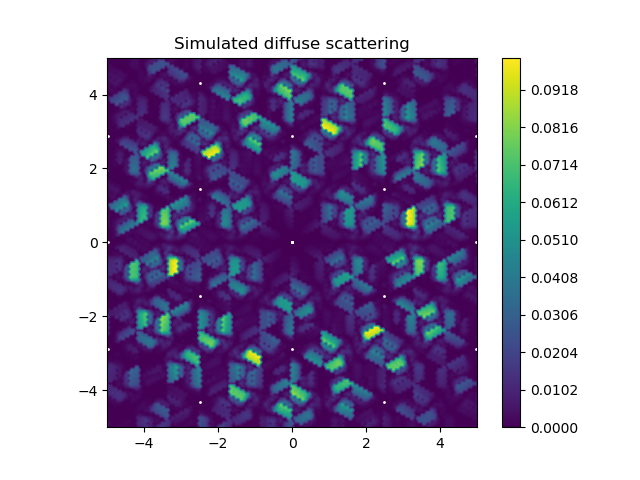

Text(0.5, 1.0, 'Simulated diffuse scattering')

In [332]:
##Plot total intensity

fig2, ax2 = plt.subplots()

tcf = ax2.tricontourf(x, y, z, levels = 1000)
plt.colorbar(tcf)

#tcf.set_clim(0, 15)

plt.xlim(-5,5)
plt.ylim(-5,5)

##Plot Bragg peaks

ax2.scatter(x_int_bragg, y_int_bragg, s = 1, color = 'w')

ax2.set_aspect('equal')
ax2.set_title('Simulated diffuse scattering')

In [158]:
print(z)

[0. 0. 0. ... 0. 0. 0.]
